Importing libraries

In [216]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt  # added for plotting
import numpy as np  # added for y-axis tick steps

Loading test data

In [217]:
send_acks_05_08_df = pd.read_csv('data/05.08.25/send_rx.csv', sep=';')
recv_05_08_df = pd.read_csv('data/05.08.25/recv_rx.csv', sep=';')
send_05_08_df = pd.read_csv('data/05.08.25/send_tx.csv', sep=';')

send_acks_07_08_df = pd.read_csv('data/07.08.25/send_rx.csv', sep=';')
recv_07_08_df = pd.read_csv('data/07.08.25/recv_rx.csv', sep=';')
send_07_08_df = pd.read_csv('data/07.08.25/send_tx.csv', sep=';')

send_acks_20_08_df = pd.read_csv('data/20.08.25/send_rx.csv', sep=';')
recv_20_08_df = pd.read_csv('data/20.08.25/recv_rx.csv', sep=';')
send_20_08_df = pd.read_csv('data/20.08.25/send_tx.csv', sep=';')

send_acks_21_08_df = pd.read_csv('data/21.08.25/send_rx.csv', sep=';')
recv_21_08_df = pd.read_csv('data/21.08.25/recv_rx.csv', sep=';')
send_21_08_df = pd.read_csv('data/21.08.25/send_tx.csv', sep=';')

send_acks_22_08_df = pd.read_csv('data/22.08.25/send_rx.csv', sep=';')
recv_22_08_df = pd.read_csv('data/22.08.25/recv_rx.csv', sep=';')
send_22_08_df = pd.read_csv('data/22.08.25/send_tx.csv', sep=';')

dataset_send = [send_05_08_df, send_07_08_df, send_20_08_df, send_21_08_df, send_22_08_df]
dataset_acks = [send_acks_05_08_df, send_acks_07_08_df, send_acks_20_08_df, send_acks_21_08_df, send_acks_22_08_df]
dataset_recv = [recv_05_08_df, recv_07_08_df, recv_20_08_df, recv_21_08_df, recv_22_08_df]
dataset_i = [0, 1, 2, 3, 4]

used_ds_send = []
used_ds_acks = []
used_ds_recv = []
for i in dataset_i:
    used_ds_send.append(dataset_send[i])
    used_ds_acks.append(dataset_acks[i])
    used_ds_recv.append(dataset_recv[i])

send_df = pd.concat(used_ds_send, ignore_index=True)
send_acks_df = pd.concat(used_ds_acks, ignore_index=True)
recv_df = pd.concat(used_ds_recv, ignore_index=True)

# Convert timestamp columns to datetime objects
send_df['Timestamp'] = pd.to_datetime(send_df['Timestamp'])
send_acks_df['Timestamp'] = pd.to_datetime(send_acks_df['Timestamp'])
recv_df['Timestamp'] = pd.to_datetime(recv_df['Timestamp'])

Sorting by timestamp

In [218]:
# Sort dataframes by timestamp
send_df = send_df.sort_values(by='Timestamp').reset_index(drop=True)
send_acks_df = send_acks_df.sort_values(by='Timestamp').reset_index(drop=True)
recv_df = recv_df.sort_values(by='Timestamp').reset_index(drop=True)

Helper functions

In [219]:
def split_batches(df, gap_seconds=60):
    df = df.sort_values('Timestamp').reset_index(drop=True)
    time_diff = df['Timestamp'].diff().dt.total_seconds().fillna(0)
    batch_breaks = time_diff > gap_seconds
    batch_ids = batch_breaks.cumsum()
    batches = [batch for _, batch in df.groupby(batch_ids)]
    return batches

def get_next_batch(batches, timestamp, max_delay_seconds=60):
    for batch in batches:
        first_ts = batch.iloc[0]['Timestamp']
        if pd.Timedelta(0) <= (first_ts - timestamp) <= pd.Timedelta(seconds=max_delay_seconds):
            return batch
    return None

def get_limited_batch(from_tsmp, to_tsmp, df):
    return df[(df['Timestamp'] >= from_tsmp) & (df['Timestamp'] <= to_tsmp)]

In [220]:
sizes = send_df['Msg Size'].unique()
print('Packet sizes:', sizes)

Packet sizes: [  7  16  26  56 106]


In [221]:
# Collect records for plotting (one row per batch with ACK data)
ack_per_distance_records = []

for sz in sizes:
    # recv_by_sz = recv_df[recv_df['Msg Size'] == sz]
    send_by_sz = send_df[send_df['Msg Size'] == sz]

    send_batches = split_batches(send_by_sz)
    # recv_batches = split_batches(recv_by_sz)
    print("Size: ", sz)
    print("Number of send_batches: ", len(send_batches))
    print()

    batch_len = 20
    for i, batch in enumerate(send_batches):
        if len(batch) != batch_len:
            print("Warning: Batch length is not equal to expected length:", len(batch), "!= ", batch_len)

        print("Batch", len(batch), " from: ", batch.iloc[0]['Timestamp'], " to ", batch.iloc[-1]['Timestamp'])

        wait_for_ack = 6
        recv_per = get_limited_batch(batch.iloc[0]['Timestamp'] - timedelta(seconds=1), batch.iloc[-1]['Timestamp'] + timedelta(seconds=wait_for_ack), recv_df)

        if recv_per is not None:
            recv_ratio = len(recv_per) / len(batch)
            print('PER', i, ': ', recv_ratio)
        else:
            recv_ratio = None
            print('PER', i, ': No matching batch found')

        ack_batch = get_limited_batch(batch.iloc[0]['Timestamp'], batch.iloc[-1]['Timestamp'] + timedelta(seconds=wait_for_ack), send_acks_df)
        if ack_batch is not None and not ack_batch.empty:
            distance = ack_batch['Avg Distance, m'].mean()
            per = len(ack_batch) / len(batch)
            if distance > 500:
                print('Warning: Distance seems too large', distance)
                print()
                continue
            print('ACK PER', i, ': ', per)
            print('Avg Distance: ', distance)
            if pd.notna(distance):
                ack_per_distance_records.append({
                    'Msg Size': sz,
                    'Distance': distance // 10 * 10,
                    'PER': per,
                    'Recv_PER': recv_ratio
                })
        else:
            print('ACK PER', i, ': No matching batch found')
        print()

    print()

Size:  7
Number of send_batches:  23

Batch 20  from:  2025-08-05 16:19:07.568000  to  2025-08-05 16:19:21.615000
PER 0 :  1.0
ACK PER 0 :  1.0
Avg Distance:  10.0

Batch 40  from:  2025-08-07 16:06:03.662000  to  2025-08-07 16:09:39.104000
PER 1 :  0.025
ACK PER 1 :  0.925
Avg Distance:  34.7

Batch 20  from:  2025-08-07 16:36:16.158000  to  2025-08-07 16:37:46.166000
PER 2 :  0.0
ACK PER 2 :  0.65
Avg Distance:  66.68153846153847

Batch 20  from:  2025-08-07 16:41:39.031000  to  2025-08-07 16:43:13.038000
PER 3 :  0.45
ACK PER 3 :  0.6
Avg Distance:  66.715

Batch 25  from:  2025-08-07 16:55:34.213000  to  2025-08-07 16:57:48.223000
PER 4 :  0.0
ACK PER 4 : No matching batch found

Batch 20  from:  2025-08-07 16:59:03.775000  to  2025-08-07 17:00:21.770000
PER 5 :  1.0
ACK PER 5 :  1.0
Avg Distance:  66.77449999999999

Batch 20  from:  2025-08-07 17:08:11.470000  to  2025-08-07 17:09:19.032000
PER 6 :  1.0
ACK PER 6 :  0.7
Avg Distance:  66.63071428571428

Batch 20  from:  2025-08-20

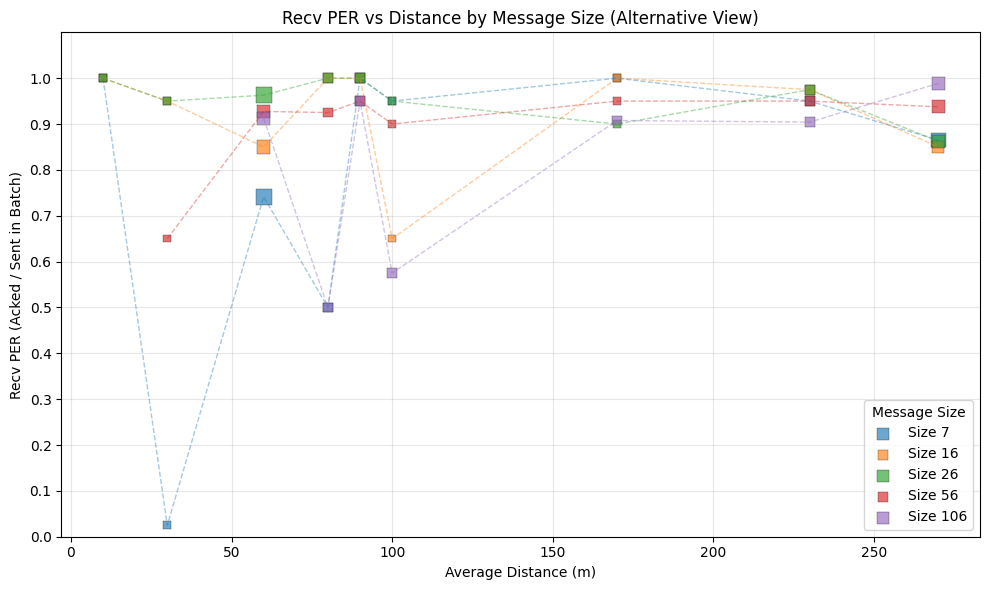

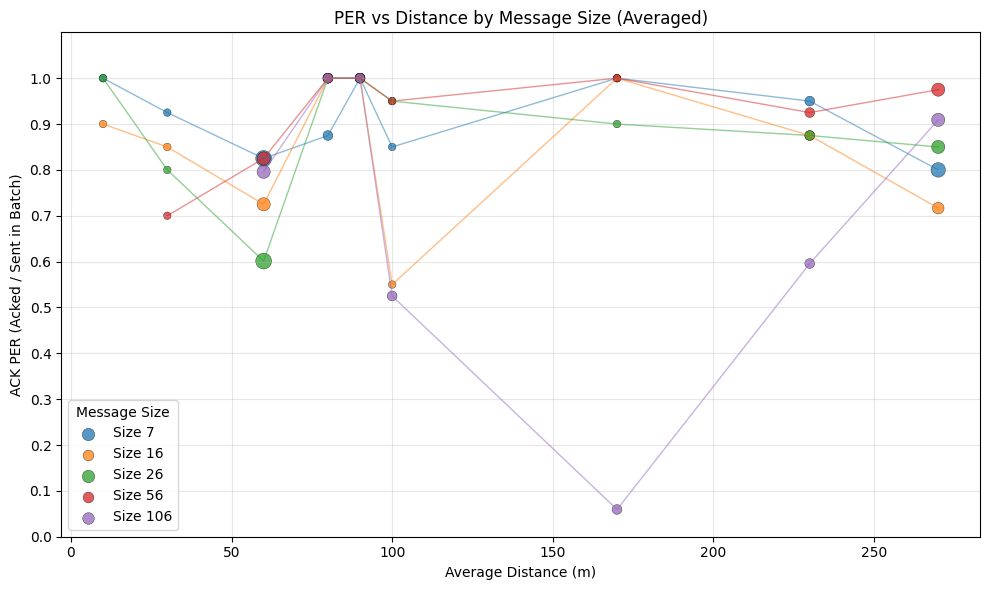

In [222]:
# After processing all sizes, build and plot PER vs Distance
if ack_per_distance_records:
    per_distance_df = pd.DataFrame(ack_per_distance_records)
    agg_dict = {'PER': ('PER', 'mean'), 'Samples': ('PER', 'count')}
    if 'Recv_PER' in per_distance_df.columns:
        agg_dict['Recv_PER'] = ('Recv_PER', 'mean')
    aggregated = (
        per_distance_df
        .groupby(['Msg Size', 'Distance'], as_index=False)
        .agg(**agg_dict)
    )
    aggregated = aggregated.sort_values(['Msg Size', 'Distance'])

    # Additional alternative plot using PER (ACK PER) instead of Recv_PER per request
    plt.figure(figsize=(10, 6))
    for sz, grp in aggregated.groupby('Msg Size'):
        sizes_marker = grp['Samples'].apply(lambda c: 30 + (c - 1) * 20)
        plt.scatter(grp['Distance'], grp['Recv_PER'], s=sizes_marker, marker='s', label=f'Size {sz}', alpha=0.65, edgecolor='k', linewidth=0.3)
        plt.plot(grp['Distance'], grp['Recv_PER'], linewidth=1, alpha=0.4, linestyle='--')
    plt.xlabel('Average Distance (m)')
    plt.ylabel('Recv PER (Acked / Sent in Batch)')
    plt.ylim(0, 1.1)
    plt.yticks(np.arange(0, 1.01, 0.1))
    plt.title('Recv PER vs Distance by Message Size (Alternative View)')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Message Size')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    for sz, grp in aggregated.groupby('Msg Size'):
        # Scale marker size by number of samples (min 30)
        sizes_marker = grp['Samples'].apply(lambda c: 30 + (c - 1) * 20)
        plt.scatter(grp['Distance'], grp['PER'], s=sizes_marker, label=f'Size {sz}', alpha=0.75, edgecolor='k', linewidth=0.3)
        plt.plot(grp['Distance'], grp['PER'], linewidth=1, alpha=0.5)

    plt.xlabel('Average Distance (m)')
    plt.ylabel('ACK PER (Acked / Sent in Batch)')
    # plt.ylim(0, 1)
    plt.ylim(0, 1.1)
    plt.yticks(np.arange(0, 1.01, 0.1))  # 0.1 step ticks
    plt.title('PER vs Distance by Message Size (Averaged)')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Message Size')
    plt.tight_layout()
    plt.show()
    # Optionally save: plt.savefig('per_distance_plot.png', dpi=150)
else:
    print("No ACK batch data collected; skipping plot generation.")

PER bar plot for message size 7

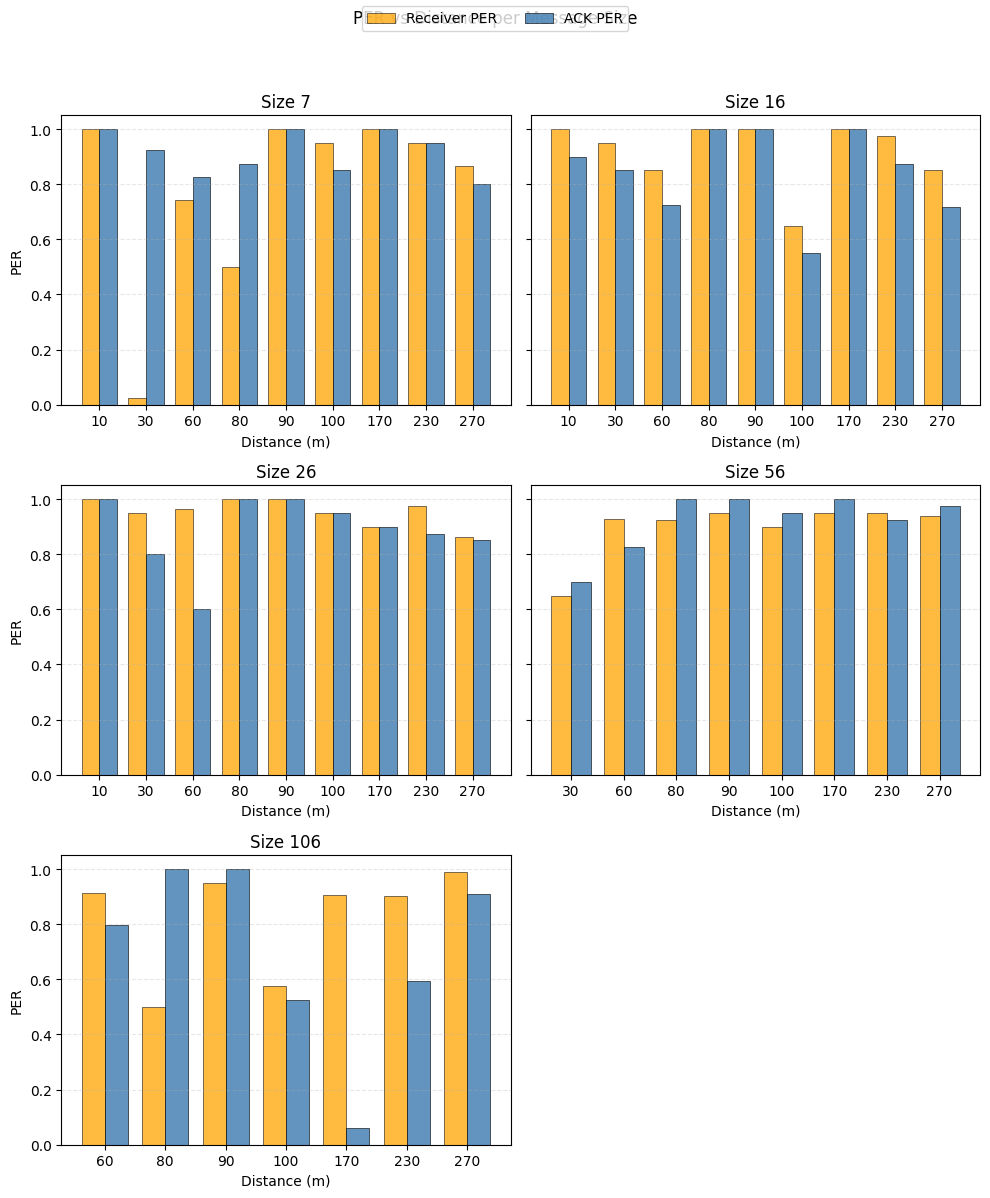

In [223]:
# Bar plots for PER vs Distance for each available message size
if 'ack_per_distance_records' in globals() and ack_per_distance_records:
    agg_available = 'aggregated' in globals() and isinstance(globals().get('aggregated'), pd.DataFrame)
    base_df = globals()['aggregated'].copy() if agg_available else pd.DataFrame(ack_per_distance_records)
    if base_df.empty:
        print('No PER data available to plot.')
    else:
        all_sizes = sorted(base_df['Msg Size'].unique())
        n = len(all_sizes)
        ncols = 2
        nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 4 * nrows), sharey=True)
        axes = np.array(axes).reshape(nrows, ncols)
        global_ylim = 0
        # Pre-compute size dataframes
        size_dfs = {}
        for TARGET_MSG_SIZE in all_sizes:
            if agg_available:
                size_df = base_df[base_df['Msg Size'] == TARGET_MSG_SIZE].copy()
            else:
                per_distance_df = base_df.copy()
                agg_dict = {'PER': ('PER', 'mean'), 'Samples': ('PER', 'count')}
                if 'Recv_PER' in per_distance_df.columns:
                    agg_dict['Recv_PER'] = ('Recv_PER', 'mean')
                size_df = (per_distance_df[per_distance_df['Msg Size'] == TARGET_MSG_SIZE]
                           .groupby(['Msg Size', 'Distance'], as_index=False)
                           .agg(**agg_dict))
            size_df = size_df.sort_values('Distance')
            size_dfs[TARGET_MSG_SIZE] = size_df
            if not size_df.empty:
                global_ylim = max(global_ylim, size_df['PER'].max(), size_df.get('Recv_PER', pd.Series([0])).max())
        # Plot
        for idx, TARGET_MSG_SIZE in enumerate(all_sizes):
            r, c = divmod(idx, ncols)
            ax = axes[r][c]
            size_df = size_dfs[TARGET_MSG_SIZE]
            if size_df.empty:
                ax.text(0.5, 0.5, f'No data for size {TARGET_MSG_SIZE}', ha='center', va='center')
                ax.axis('off')
                continue
            distances = size_df['Distance'].astype(int)
            x = np.arange(len(distances))
            width = 0.38
            ack_vals = size_df['PER']
            recv_vals = size_df['Recv_PER'] if 'Recv_PER' in size_df.columns else None
            if recv_vals is not None:
                ax.bar(x - width/2, recv_vals, width, label='Receiver PER', color='orange', alpha=0.75, edgecolor='k', linewidth=0.5)
                ax.bar(x + width/2, ack_vals, width, label='ACK PER', color='steelblue', alpha=0.85, edgecolor='k', linewidth=0.5)
            else:
                ax.bar(x, ack_vals, width, label='ACK PER', color='steelblue', alpha=0.85, edgecolor='k', linewidth=0.5)
            ax.set_title(f'Size {TARGET_MSG_SIZE}')
            ax.set_xticks(x)
            ax.set_xticklabels(distances, rotation=0)
            ax.set_xlabel('Distance (m)')
            if c == 0:
                ax.set_ylabel('PER')
            ax.grid(axis='y', linestyle='--', alpha=0.3)
        # Hide unused axes
        for j in range(n, nrows * ncols):
            r, c = divmod(j, ncols)
            axes[r][c].axis('off')
        # Unified legend
        handles, labels = [], []
        for ax in axes.flat:
            for h, l in zip(*ax.get_legend_handles_labels()):
                if l not in labels:
                    handles.append(h); labels.append(l)
        if handles:
            fig.legend(handles, labels, loc='upper center', ncol=len(labels))
        ylim_val = max(1.0, global_ylim * 1.05)
        for ax in axes.flat:
            if ax.has_data():
                ax.set_ylim(0, ylim_val)
        fig.suptitle('PER vs Distance per Message Size', y=0.995)
        plt.tight_layout(rect=(0, 0, 1, 0.965))
        del base_df, size_dfs, size_df
else:
    print('No ACK batch data collected; cannot create bar plots for all sizes.')
